# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn, preprocess_dataset, EarlyStopper

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {},{},{},{}  #creating our dictionaries to return


    cv = KFold(n_splits = 5, shuffle=False)


    for batch_size in parameters:

        #initialising the values of the keys (batch size) in the dictionary as lists
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            x_train_fold, y_train_fold  = X_train[train_idx], y_train[train_idx]
            x_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

            #scaling X values using preprocess_dataset() function is common_utils
            x_train_scaled_fold, x_val_scaled_fold = preprocess_dataset(x_train_fold, x_val_fold)

            X_train_scaled_dict[batch_size].append(x_train_scaled_fold)
            X_val_scaled_dict[batch_size].append(x_val_scaled_fold)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)





    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict


#obtaining our X_train and y_train
label_encoder = preprocessing.LabelEncoder()

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'] = label_encoder.fit_transform(df['label'])  #changing the labels from neg/pos to 1/0

y = df['label'].to_numpy()
X = df.drop(["filename","label"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)


batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [4]:
# YOUR CODE HERE


#using the same settings as our model in A1
no_features = 77
no_hidden = 128
no_labels = 2
lr = 0.001
no_epochs = 100




#implementing train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        y_long = y.type(torch.LongTensor)
        loss = loss_fn(pred, y_long)

        # Backpropagation
        optimizer.zero_grad()  #initialize gradient calculations
        loss.backward()  #compute gradients
        optimizer.step()  #take one step of SGD

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    return train_loss, correct




#implementing test loop
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y_long = y.type(torch.LongTensor)
            test_loss += loss_fn(pred, y_long).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    return test_loss, correct





def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, mode):

    fold = [0,1,2,3,4] #index for our 5-folds

    cv_accuracies = [] #this is contain the 4 mean accuracy values for the 4 batch sizes
    cv_times = [] #this contains the time taken to train the network on the last epoch

    for batch_size in batch_sizes:
        print("Batch_size: ", batch_size)

        batchFoldAcc = []  #this is to contain the 5 accuracy values of the last epoch, for the 5-folds, which we will take the mean after
        batchFoldTime = []  #this is to contain the 5 time taken to train the network for the last epoch, for the 5-folds, which we will take the mean after

        #looping through folds
        for idx in fold:
            print("Fold ", idx+1)

            train_data = CustomDataset(X_train_scaled_dict[batch_size][idx], y_train_dict[batch_size][idx])
            val_data = CustomDataset(X_val_scaled_dict[batch_size][idx], y_val_dict[batch_size][idx])

            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)



            model = MLP(no_features, no_hidden, no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = torch.nn.CrossEntropyLoss()


            #initialising early stopper for each fold before we begin training
            early_stopper = EarlyStopper(min_delta = 0.00005) #min_delta = 0.00005
            early_stopper_bool = False




            for epoch in range(no_epochs):
                t = 0

                #start time
                start_time = time.time()

                train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
                val_loss, val_acc = test_loop(val_dataloader, model, loss_fn)

                t += time.time() - start_time

                #early stopper used on val_loss
                early_stopper_bool = early_stopper.early_stop(val_loss)
                if early_stopper_bool:
                    print(f"Early stopped at {epoch+1}!")
                    break




            print("Last epoch accuracy value: ", val_acc)
            batchFoldAcc.append(val_acc) #appending the last epoch accuracy value of each fold to the list

            print("Last epoch time taken: ", t)
            batchFoldTime.append(t) #appending last epoch time of each fold to the list



        meanAcc = np.mean(batchFoldAcc) #obtaining the mean cv accuracy
        print(f"\nMean CV accuracy for batch size {batch_size}: {meanAcc}")

        meanTime = np.mean(batchFoldTime) #obtaining the mean time
        print(f"Mean time taken to train network on last epoch for batch size {batch_size}: {meanTime} \n")
        print("----------------------------------------")


        cv_accuracies.append(meanAcc)
        cv_times.append(meanTime)

    return cv_accuracies, cv_times



cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')



Batch_size:  128
Fold  1
Early stopped at 37!
Last epoch accuracy value:  0.7067535545023697
Last epoch time taken:  0.6548237800598145
Fold  2
Early stopped at 13!
Last epoch accuracy value:  0.6492890995260664
Last epoch time taken:  0.6780707836151123
Fold  3
Early stopped at 21!
Last epoch accuracy value:  0.6605450236966824
Last epoch time taken:  0.667773962020874
Fold  4
Early stopped at 18!
Last epoch accuracy value:  0.6800947867298578
Last epoch time taken:  0.21999478340148926
Fold  5
Early stopped at 25!
Last epoch accuracy value:  0.6769413159454654
Last epoch time taken:  0.670621395111084

Mean CV accuracy for batch size 128: 0.6747247560800883
Mean time taken to train network on last epoch for batch size 128: 0.5782569408416748 

----------------------------------------
Batch_size:  256
Fold  1
Early stopped at 34!
Last epoch accuracy value:  0.6877962085308057
Last epoch time taken:  0.5024075508117676
Fold  2
Early stopped at 80!
Last epoch accuracy value:  0.70082938

5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

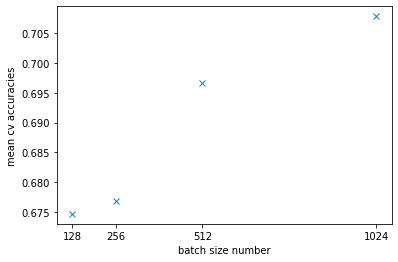

In [5]:
# YOUR CODE HERE

plt.figure(1)
plt.plot(batch_sizes, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.xticks(batch_sizes)
plt.xlabel('batch size number')
plt.ylabel('mean cv accuracies')
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [6]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': cross_validation_times
                  })
df

,Batch Size,Last Epoch Time
0,128,0.578257
1,256,0.521794
2,512,0.202884
3,1024,0.137429


In [7]:
# YOUR CODE HERE
optimal_batch_size = 1024
reason = "This batch size provided the highest Mean CV Accuracy while having the shortest last epoch timing too. We notice that\
as batch size increases, the epochs where early stopping kicked in also increases. There was no early stopping during the\
training for batch size = 1024. This suggest that there was no overfitting and thus i selected it as the optimal batch size."